# Artpedia Dataset Analysis

Import necessary libraries.

In [33]:
import ssl
import json
import nltk
import shutil
import requests
import pandas as pd
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean, median

Load the dataset.

In [3]:
def download_file(link, path):
    r = requests.get(link)
    z = ZipFile(BytesIO(r.content))
    z.extractall(path)

download_file('https://aimagelab.ing.unimore.it/imagelab/uploadedFiles/artpedia.zip', 'artpedia/')

In [40]:
with open('artpedia.json') as json_file:
    dataset = json.load(json_file)

Download the images and save them in the `imgs` folder. Some images are not available anymore, so a new property `got_img` is added to the dataset to keep track of the images that were downloaded.

In [38]:
imgs_path = Path('imgs')
imgs_path.mkdir(parents=True, exist_ok=True)
headers = {
    'User-Agent': 'CoolBot/0.0 (https://example.org/coolbot/; coolbot@example.org) generic-library/0.0'
}

with requests.Session() as session:
    for key, data in dataset.items():
        url = data['img_url']
        file_name = imgs_path / f'{key}_{url.split("/")[-1]}'
        res = session.get(str(url), headers=headers, stream=True)
        if res.status_code == 200:
            with open(file_name,'wb') as f:
                shutil.copyfileobj(res.raw, f)
            data['got_img'] = 'yes'
        else:
            data['got_img'] = 'no'
            print(f'Error: {res.status_code} - {res.text}')

Save the dataset in `artpedia_res.json` in the same folder.

In [6]:
with open('artpedia_res.json', 'w') as f:
    json.dump(dataset, f)

Load the dataset here later if needed.

In [2]:
with open('artpedia_res.json') as json_file:
    dataset = json.load(json_file)

Calculate some statistics on the visual sentences of the dataset.

In [39]:
all_characters = []
all_words = []
for _, entry in dataset.items():
    for vs in entry['visual_sentences']:
        character = len(vs)
        words = len(vs.split())
        all_characters.append(character)
        all_words.append(words)

In [40]:
print(f'The longest visual sentence based on number of characters is {max(all_characters)} characters long.')
print(f'The shortest visual sentence based on number of characters is {min(all_characters)} characters long.')
print(f'On average a visual sentence consists of {mean(all_characters)} characters.')

The longest visual sentence based on number of characters is 924 characters long.
The shortest visual sentence based on number of characters is 4 characters long.
On average a visual sentence consists of 128.35626294560123 characters.


In [41]:
print(f'The longest visual sentence based on number of words is {max(all_words)} words long.')
print(f'The shortest visual sentence based on number of words is {min(all_words)} words long.')
print(f'On average a visual sentence consists of {mean(all_words)} words.')

The longest visual sentence based on number of words is 158 words long.
The shortest visual sentence based on number of words is 1 words long.
On average a visual sentence consists of 22.359097350921182 words.


Setting up the plots.

In [70]:
COLORS = [
  '#797979',
  '#e0736e',
  '#aaaaaa',
]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)
plt.style.use('seaborn-v0_8-whitegrid')

plots_path = Path('plots')
plots_path.mkdir(parents=True, exist_ok=True)

How many characters does a visual sentence have on average?

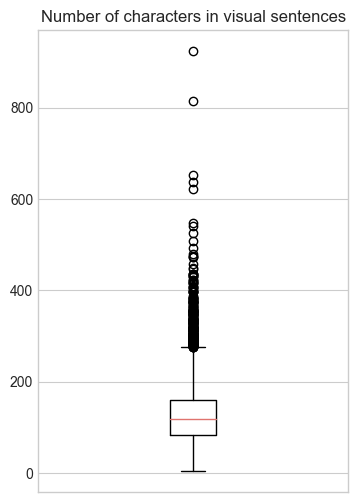

In [49]:
plt.figure(figsize=(4, 6))
plt.boxplot(all_characters)
plt.title('Number of characters in visual sentences')
plt.xticks([])
plt.savefig(plots_path / 'viz_sentences_chars.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

How many words does a visual sentence have on average?

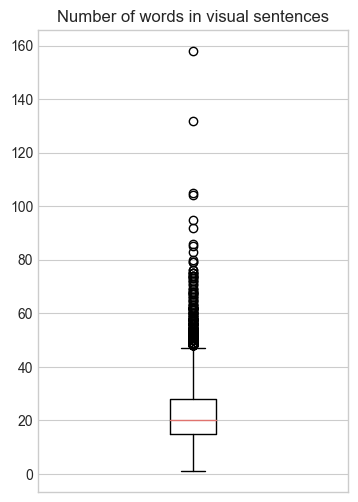

In [51]:
plt.figure(figsize=(4, 6))
plt.boxplot(all_words)
plt.title('Number of words in visual sentences')
plt.xticks([])
plt.savefig(plots_path / 'viz_sentences_words.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

The captions have been assessed by BLIPs filter. The script can be found in the LAVIS-submodule under `caption_matching.py`. Load the results into a dataframe which are saved in `artpedia_res_scored_train.json`.

In [5]:
scored_df = pd.read_json('new_artpedia.json')
scored_df = scored_df.T

Load the actual dataset into a dataframe too.

In [6]:
res_df = pd.read_json('artpedia_res.json')
res_df = res_df.T

Select only the entries that had an image available.

In [7]:
res_df = res_df[res_df['got_img'] == 'yes']

In [8]:
# just in case there are duplicates
# scored_df = scored_df.loc[scored_df.astype(str).drop_duplicates().index]

Merge the datasets, so we have all information available, especially the columns `cosine_similarities` and `matching_scores` where the results of the filter are stored.

In [9]:
cols_to_use = scored_df.columns.difference(res_df.columns)
cols_to_use = cols_to_use.tolist()
cols_to_use.append('title')
df = pd.merge(res_df, scored_df[cols_to_use], on='title').set_index(res_df.index)

In [11]:
scores = df['matching_scores'].tolist()
all_scores = []
for s in scores:
    for score in s:
        all_scores.append(float(score.split('%')[0]))

In [56]:
print(f'Median of scores: {median(all_scores)}')

Median of scores: 77.786


How did the filter assess the captions? What are the scores?

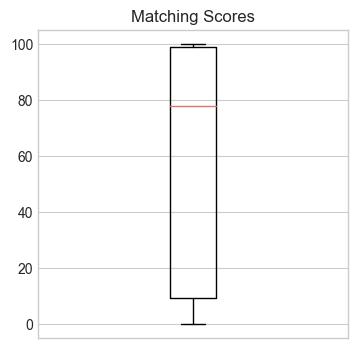

In [66]:
plt.figure(figsize=(4, 4))
plt.boxplot(all_scores)
plt.title('Matching Scores')
plt.xticks([])
plt.savefig(plots_path / 'matching_scores.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

How does the distribution of the scores look like?

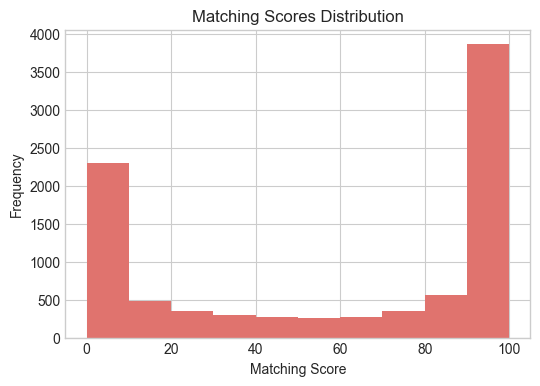

In [67]:
plt.figure(figsize=(6, 4))
plt.hist(all_scores, color = COLORS[1])
plt.title('Matching Scores Distribution')
plt.ylabel('Frequency')
plt.xlabel('Matching Score')
plt.savefig(plots_path / 'matching_scores_dist.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

What are the statistics of the scores?

In [17]:
pd.Series(all_scores).describe()

count    9014.000000
mean       58.788353
std        41.406467
min         0.001000
25%         9.316500
50%        77.786000
75%        98.962500
max        99.997000
dtype: float64

In [52]:
print(f'Min score: {min(all_scores)}')

Min score: 0.001


Load the evaluation of the pre-trained base model.

In [19]:
pretrained = pd.read_json('../output/base_model/evaluate.json')
pretrained = pretrained.T.rename(index={'test': 'pretrained'})

In [20]:
finetuned = pd.read_json('../output/finetuned_model/evaluate.json')
finetuned = finetuned.T.rename(index={'test': 'finetuned'})

In [21]:
metrics_df = pd.concat([pretrained, finetuned])
metrics_df = metrics_df[['Bleu_4', 'CIDEr', 'SPICE']]

Plot the relevant evaluation metrics.

<Figure size 400x400 with 0 Axes>

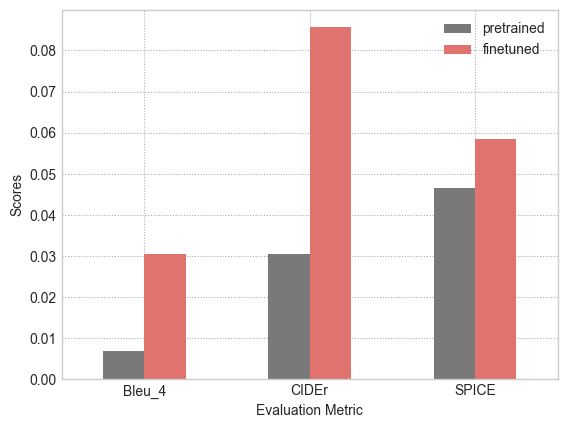

In [38]:
plt.figure(figsize=(4, 4))
metrics_df.T.plot.bar()
plt.ylabel('Scores')
plt.xlabel('Evaluation Metric')
plt.xticks(rotation=0)
plt.legend(loc = 'upper right')
plt.grid(color = COLORS[2], linestyle = 'dotted', linewidth = 0.75)
plt.savefig('../output/base_finetuned.png', bbox_inches = 'tight', transparent=True, dpi=1200)
plt.show()

Plot the distribution of the years of origin.

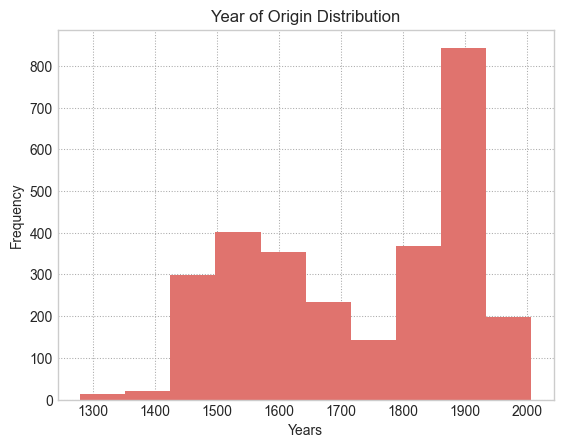

In [68]:
plt.hist(df['year'].tolist(), color = COLORS[1])
plt.grid(color = COLORS[2], linestyle = 'dotted', linewidth = 0.75)
plt.title('Year of Origin Distribution')
plt.ylabel('Frequency')
plt.xlabel('Years')
plt.savefig(plots_path / 'years.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()

Number of available images in the dataset:

In [53]:
print(f'Number of available painting: {len(df)}')

Number of available painting: 2875


In [57]:
print(f'Number of all visual sentences of available paintings: {df["visual_sentences"].str.len().sum()}')

Number of all visual sentences of available paintings: 9014


In [17]:
out_count = 0
in_count = 0
for viz in df['visual_sentences'].tolist():
    for sentence in viz:
        in_count += 1
    out_count += 1

Average number of visual sentences per image:

In [27]:
in_count / out_count

3.135304347826087

Take the corpus of the visual sentences and remove the stop words.

In [18]:
ps = nltk.stem.PorterStemmer()

In [59]:
all_words = []
for viz_sentence_listy in df['visual_sentences'].tolist():
    for sentence in viz_sentence_listy:
        for word in sentence.split(' '):
            if (word != '') and (word != 'also'):
                all_words.append(word)

In [60]:
# in some cases, when trying to download corpora from the NLTK library, you may encounter SSL verification errors
# run this cell set the default HTTPS context to the unverified context
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [21]:
# download the stopwords corpus from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valeriatisch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [23]:
filtered_words = [w for w in all_words if not w.lower() in stop_words]

In [55]:
print(f'Number of all unique words from the visual sentences: {len(set(all_words))}')
print(f'Number of all unique words excluding the stop words: {len(set(filtered_words))}')
print(f'Number of stop words: {len(set(all_words)) - len(set(filtered_words))}')

Number of all unique words from the visual sentences: 87
Number of all unique words excluding the stop words: 28325
Number of stop words: -28238


What are the most frequent words?

In [24]:
occurence_count_most = Counter(filtered_words).most_common(15)
occurence_count_most

[('painting', 1426),
 ('depicts', 772),
 ('left', 726),
 ('two', 662),
 ('shows', 661),
 ('right', 647),
 ('woman', 405),
 ('one', 404),
 ('white', 318),
 ('red', 304),
 ('man', 304),
 ('background', 298),
 ('hand', 264),
 ('oil', 260),
 ('figure', 257)]

Plot the most frequent words.

In [65]:
word, counts = zip(*occurence_count_most)

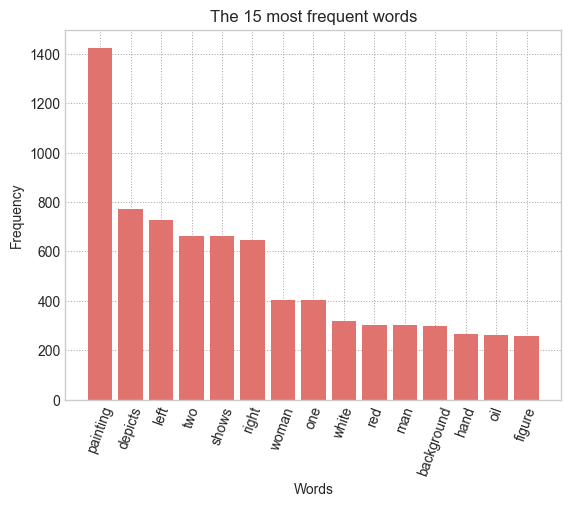

<Figure size 640x480 with 0 Axes>

In [69]:
plt.bar(word, counts, color = COLORS[1])
plt.title('The 15 most frequent words')
plt.ylabel('Frequency')
plt.xlabel('Words')
plt.xticks(rotation=70)
plt.grid(color = COLORS[2], linestyle = 'dotted', linewidth = 0.75)
plt.savefig(plots_path / 'freq_words.png', bbox_inches='tight', transparent=True, dpi=1200)
plt.show()
plt.clf()